In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Generate dataset

In [2]:
np.random.seed(1234)
y = np.random.randint(0,4,1200)
idx= []
for i in range(4):
    print(i,sum(y==i))
    idx.append(y==i)

0 271
1 320
2 292
3 317


In [3]:
x = np.zeros((1200,3))

In [4]:
x[idx[0],0] = 1
x[idx[0],1]  = np.concatenate((np.random.uniform(low=3,high=4,size=sum(idx[0])//2), np.random.uniform(low=-3,high=-4,size= (sum(idx[0])//2) + 1 )  ))
x[idx[0],2] = np.random.uniform(low=-1,high=0.5,size= sum(idx[0])) 



x[idx[1],0] = 1
x[idx[1],1]  = np.concatenate((np.random.uniform(low=3,high=4,size=sum(idx[1])//2), np.random.uniform(low=-3,high=-4,size= (sum(idx[1])//2)  )  ))
x[idx[1],2] = np.random.uniform(low=-0.50,high=0.5,size= sum(idx[1])) 



x[idx[2],0] = 1
x[idx[2],1]  = np.concatenate((np.random.uniform(low=3,high=4,size=sum(idx[2])//2), np.random.uniform(low=-3,high=-4,size= (sum(idx[2])//2)  )  ))
x[idx[2],2] = np.random.uniform(low=0.50,high=1,size= sum(idx[2])) 




x[idx[3],0] = -1
x[idx[3],1:] = np.random.uniform(low =-1,high=1,size=(sum(idx[3]),2))

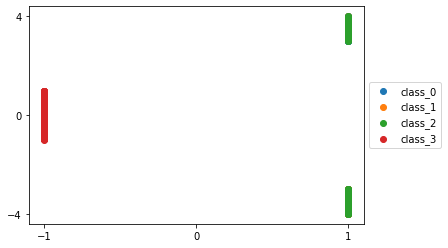

In [5]:
for i in range(4):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks([-1,0,1])
plt.yticks([-4,0,4])
plt.savefig("type3_2_dist.png",bbox_inches="tight")
plt.savefig("type3_2_dist.pdf",bbox_inches="tight")


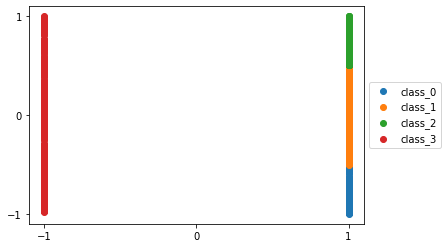

In [6]:
for i in range(4):
    plt.scatter(x[idx[i],0],x[idx[i],2],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.savefig("type3_2_dist.png",bbox_inches="tight")
plt.savefig("type3_2_dist.pdf",bbox_inches="tight")


In [7]:
foreground_classes = {'class_0','class_1', 'class_2'}

background_classes = {'class_3'}

In [8]:

fg_class  = np.random.randint(0,3)
fg_idx = np.random.randint(0,9)

a = []
for i in range(9):
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        bg_class = np.random.randint(3,4)
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 3 present at 0
background 3 present at 1
background 3 present at 2
background 3 present at 3
background 3 present at 4
background 3 present at 5
background 3 present at 6
background 3 present at 7
foreground 1 present at 8
(9, 3)
1 8


In [9]:
a.shape

(9, 3)

In [10]:
np.reshape(a,(27,1))

array([[-1.        ],
       [ 0.68503853],
       [ 0.65270614],
       [-1.        ],
       [-0.0947877 ],
       [ 0.8926987 ],
       [-1.        ],
       [-0.46513269],
       [-0.7923426 ],
       [-1.        ],
       [-0.87515681],
       [-0.48128579],
       [-1.        ],
       [ 0.28038128],
       [-0.3318334 ],
       [-1.        ],
       [ 0.63985089],
       [-0.40125188],
       [-1.        ],
       [ 0.56035668],
       [ 0.69205427],
       [-1.        ],
       [-0.444971  ],
       [ 0.45695537],
       [ 1.        ],
       [-3.76008122],
       [ 0.26801772]])

In [11]:
desired_num = 3000
mosaic_list =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,9)
    a = []
    for i in range(9):  #m=9
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,4)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list.append(np.reshape(a,(27,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [12]:
mosaic_list = np.concatenate(mosaic_list,axis=1).T
# print(mosaic_list)

In [13]:
print(np.shape(mosaic_label))
print(np.shape(fore_idx))

(3000,)
(3000,)


In [14]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [15]:
class Wherenet(nn.Module):
    def __init__(self):
        super(Wherenet,self).__init__()
        self.linear1 = nn.Linear(3,10)
        self.linear2 = nn.Linear(10,20)
        self.linear3 = nn.Linear(20,1)

    def forward(self,z):
        x = torch.zeros([batch,9],dtype=torch.float64)  #m=9
        y = torch.zeros([batch,3], dtype=torch.float64)
        #x,y = x.to("cuda"),y.to("cuda")
        for i in range(9):  #m=2
          x[:,i] = self.helper(z[:,3*i:3*i+3])[:,0]
            #print(k[:,0].shape,x[:,i].shape)
        x = F.softmax(x,dim=1)   # alphas
        x1 = x[:,0]
        for i in range(9): #m=9
            x1 = x[:,i]          
            #print()
            y = y+torch.mul(x1[:,None],z[:,3*i:3*i+3])  #d , dimension =3
        return y , x 

    
    def helper(self,x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

    

In [16]:
trainiter = iter(train_loader)
input1,labels1,index1 = trainiter.next()



In [17]:
where = Wherenet().double()
where = where
out_where,alphas = where(input1)
out_where.shape,alphas.shape

(torch.Size([250, 3]), torch.Size([250, 9]))

In [18]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(3,3)
        # self.linear2 = nn.Linear(10,20)
        # self.linear3 = nn.Linear(20,3)
    def forward(self,x):
        # x = F.relu(self.linear1(x))
        # x = F.relu(self.linear2(x))
        x = self.linear1(x)
        return x

In [19]:
what = Whatnet().double()
# what(out_where)

In [20]:
test_data_required = 1000
mosaic_list_test =[]
mosaic_label_test = []
fore_idx_test=[]
for j in range(test_data_required):
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,9)  #m=9
    a = []
    for i in range(9): #m=2
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,4)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_test.append(np.reshape(a,(27,1)))
    mosaic_label_test.append(fg_class)
    fore_idx_test.append(fg_idx)

In [21]:
mosaic_list_test = np.concatenate(mosaic_list_test,axis=1).T
print(mosaic_list_test.shape)

(1000, 27)


In [22]:
test_data = MosaicDataset(mosaic_list_test,mosaic_label_test,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [23]:

focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

criterion = nn.CrossEntropyLoss()
optimizer_where = optim.SGD(where.parameters(), lr=0.01, momentum=0.9)
optimizer_what = optim.SGD(what.parameters(), lr=0.01, momentum=0.9)

nos_epochs = 1000

train_loss=[]
test_loss =[]
train_acc = []
test_acc = []
for epoch in range(nos_epochs):  # loop over the dataset multiple times

    focus_true_pred_true =0
    focus_false_pred_true =0
    focus_true_pred_false =0
    focus_false_pred_false =0

    argmax_more_than_half = 0
    argmax_less_than_half =0

    running_loss = 0.0
    cnt=0

    iteration = desired_num // batch

    #training data set

    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        #inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device)
        # zero the parameter gradients

        optimizer_what.zero_grad()
        optimizer_where.zero_grad()
        
        
        avg_inp,alphas = where(inputs)
        
        outputs = what(avg_inp)
        
        _, predicted = torch.max(outputs.data, 1)
        
        loss = criterion(outputs, labels) 
        loss.backward() 
        
        optimizer_what.step()
        optimizer_where.step() 
        

        running_loss += loss.item()
        if cnt % 6 == 5:    # print every 6 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 6))
            running_loss = 0.0
        cnt=cnt+1
    
        if epoch % 5 == 4:
            for j in range (batch):
                focus = torch.argmax(alphas[j])

                if(alphas[j][focus] >= 0.5):
                    argmax_more_than_half +=1
                else:
                    argmax_less_than_half +=1

                if(focus == fore_idx[j] and predicted[j] == labels[j]):
                    focus_true_pred_true += 1

                elif(focus != fore_idx[j] and predicted[j] == labels[j]):
                    focus_false_pred_true +=1

                elif(focus == fore_idx[j] and predicted[j] != labels[j]):
                    focus_true_pred_false +=1

                elif(focus != fore_idx[j] and predicted[j] != labels[j]):
                    focus_false_pred_false +=1

    if epoch % 5 == 4:
        col1.append(epoch)
        col2.append(argmax_more_than_half)
        col3.append(argmax_less_than_half)
        col4.append(focus_true_pred_true)
        col5.append(focus_false_pred_true)
        col6.append(focus_true_pred_false)
        col7.append(focus_false_pred_false)

    #************************************************************************
        #testing data set  
        with torch.no_grad():
            focus_true_pred_true =0
            focus_false_pred_true =0
            focus_true_pred_false =0
            focus_false_pred_false =0

            argmax_more_than_half = 0
            argmax_less_than_half =0
            for data in test_loader:
                inputs, labels , fore_idx = data
                #inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device) 
#                 print(inputs.shtorch.save(where.state_dict(),"model_epoch"+str(epoch)+".pt")ape,labels.shape)
                avg_inp,alphas = where(inputs)
                outputs = what(avg_inp)
                _, predicted = torch.max(outputs.data, 1)

                for j in range (batch):
                    focus = torch.argmax(alphas[j])

                    if(alphas[j][focus] >= 0.5):
                        argmax_more_than_half +=1
                    else:
                        argmax_less_than_half +=1

                    if(focus == fore_idx[j] and predicted[j] == labels[j]):
                        focus_true_pred_true += 1

                    elif(focus != fore_idx[j] and predicted[j] == labels[j]):
                        focus_false_pred_true +=1

                    elif(focus == fore_idx[j] and predicted[j] != labels[j]):
                        focus_true_pred_false +=1

                    elif(focus != fore_idx[j] and predicted[j] != labels[j]):
                        focus_false_pred_false +=1

        col8.append(argmax_more_than_half)
        col9.append(argmax_less_than_half)
        col10.append(focus_true_pred_true)
        col11.append(focus_false_pred_true)
        col12.append(focus_true_pred_false)
        col13.append(focus_false_pred_false)
        
        #torch.save(where.state_dict(),"where_model_epoch"+str(epoch)+".pt")
        #torch.save(what.state_dict(),"what_model_epoch"+str(epoch)+".pt")
    
print('Finished Training')
#torch.save(where.state_dict(),"where_model_epoch"+str(nos_epochs)+".pt")
#torch.save(what.state_dict(),"what_model_epoch"+str(epoch)+".pt")


[1,     6] loss: 1.120
[1,    12] loss: 1.122
[2,     6] loss: 1.119
[2,    12] loss: 1.117
[3,     6] loss: 1.114
[3,    12] loss: 1.116
[4,     6] loss: 1.112
[4,    12] loss: 1.112
[5,     6] loss: 1.107
[5,    12] loss: 1.113
[6,     6] loss: 1.110
[6,    12] loss: 1.106
[7,     6] loss: 1.107
[7,    12] loss: 1.106
[8,     6] loss: 1.108
[8,    12] loss: 1.101
[9,     6] loss: 1.104
[9,    12] loss: 1.103
[10,     6] loss: 1.100
[10,    12] loss: 1.104
[11,     6] loss: 1.102
[11,    12] loss: 1.100
[12,     6] loss: 1.100
[12,    12] loss: 1.100
[13,     6] loss: 1.099
[13,    12] loss: 1.100
[14,     6] loss: 1.099
[14,    12] loss: 1.097
[15,     6] loss: 1.098
[15,    12] loss: 1.097
[16,     6] loss: 1.098
[16,    12] loss: 1.096
[17,     6] loss: 1.095
[17,    12] loss: 1.096
[18,     6] loss: 1.095
[18,    12] loss: 1.095
[19,     6] loss: 1.095
[19,    12] loss: 1.094
[20,     6] loss: 1.094
[20,    12] loss: 1.094
[21,     6] loss: 1.093
[21,    12] loss: 1.093
[22,     6

In [24]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [25]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,4,0,3000,115,755,145,1985
1,9,0,3000,0,1065,0,1935
2,14,0,3000,0,1137,0,1863
3,19,0,3000,0,1182,0,1818
4,24,0,3000,375,825,512,1288
...,...,...,...,...,...,...,...
195,979,3000,0,2210,0,790,0
196,984,3000,0,2209,0,791,0
197,989,3000,0,2191,0,809,0
198,994,3000,0,2205,0,795,0


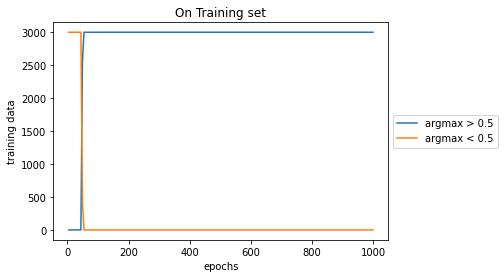

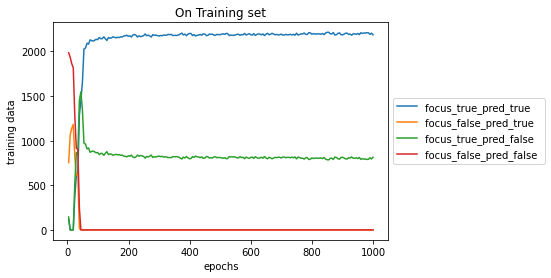

In [26]:
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.savefig("linear_type3_21.png",bbox_inches="tight")
plt.savefig("linear_type3_21.pdf",bbox_inches="tight")
plt.show()

In [27]:
df_test

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,4,0,1000,14,280,8,698
1,9,0,1000,0,335,0,665
2,14,0,1000,0,348,0,652
3,19,0,1000,0,363,0,637
4,24,0,1000,181,179,272,368
...,...,...,...,...,...,...,...
195,979,1000,0,735,0,265,0
196,984,1000,0,731,0,269,0
197,989,1000,0,725,0,275,0
198,994,1000,0,731,0,269,0


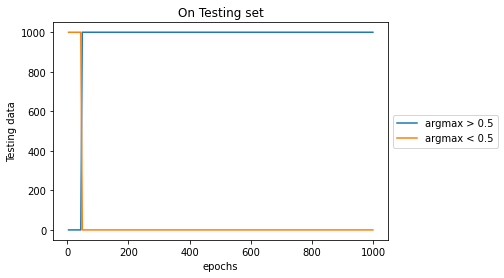

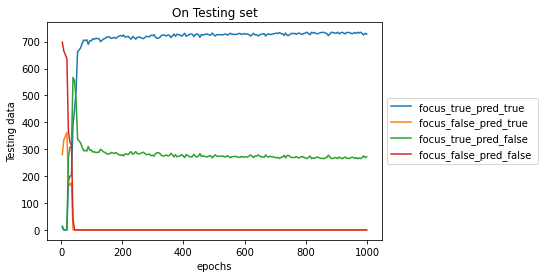

In [28]:
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.show()

In [29]:
# where.state_dict()["linear1.weight"][:]  = torch.Tensor(np.array([[ 0, -1]]))
# where.state_dict()["linear1.bias"][:] = torch.Tensor(np.array([0]))

In [30]:
for param in where.named_parameters():
  print(param)

('linear1.weight', Parameter containing:
tensor([[ 0.3437,  0.2160, -0.3932],
        [-0.4975,  0.5882,  0.2168],
        [-0.3712,  0.0752,  0.3128],
        [-0.3006,  0.0633, -0.1035],
        [-0.3455,  0.1212,  0.1628],
        [-0.6248, -0.0222, -0.4221],
        [-0.5323,  0.3653,  0.1107],
        [ 0.7140,  1.0678, -0.4284],
        [ 0.2770,  0.8670,  0.1662],
        [ 0.7818, -1.1762, -0.0404]], dtype=torch.float64, requires_grad=True))
('linear1.bias', Parameter containing:
tensor([-0.0769,  0.1328, -0.2241, -0.2255, -0.2254,  0.6557,  0.5815, -0.2173,
         0.4125,  0.2434], dtype=torch.float64, requires_grad=True))
('linear2.weight', Parameter containing:
tensor([[ 3.3390e-01,  1.0662e-01, -5.5219e-02, -4.2966e-02,  2.1819e-01,
         -1.9960e-02, -5.4323e-02,  3.1658e-01,  2.1501e-01, -2.7200e-01],
        [ 2.3898e-01,  6.3465e-02,  3.1177e-01,  1.5447e-01, -3.7563e-02,
          4.3917e-01,  3.0921e-01, -9.7226e-02, -1.6931e-01, -1.0297e-01],
        [-2.3067e-0

In [31]:
# what.state_dict()["linear1.weight"][:]  = torch.Tensor(np.array([[ 4.0075, -2.7007],
#         [-0.7772,  2.6867],
#         [-1.6794,  0.9356]]))
# what.state_dict()["linear1.bias"][:] = torch.Tensor(np.array([-2.7580, -3.0382,  6.3862]))

In [32]:
for param in what.named_parameters():
  print(param)

('linear1.weight', Parameter containing:
tensor([[ 1.1994, -0.2148, -6.2434],
        [ 1.4516, -0.2048, -4.7972],
        [-2.0528, -0.2535, 10.8779]], dtype=torch.float64, requires_grad=True))
('linear1.bias', Parameter containing:
tensor([ 1.4558,  1.4933, -2.1919], dtype=torch.float64, requires_grad=True))


In [33]:
xx,yy,zz= np.meshgrid(np.arange(-1.2,1.5,0.01),np.arange(-4,4.5),np.arange(-1,1))
X = np.concatenate((xx.reshape(-1,1),yy.reshape(-1,1),zz.reshape(-1,1)),axis=1)
X = torch.Tensor(X).double()
Y = where.helper(X)
Y1 = what(X)

In [34]:
X.shape,Y.shape

(torch.Size([4860, 3]), torch.Size([4860, 1]))

In [35]:
X = X.detach().numpy()
Y = Y[:,0].detach().numpy()

In [36]:
xx.shape,X.shape

((9, 270, 2), (4860, 3))

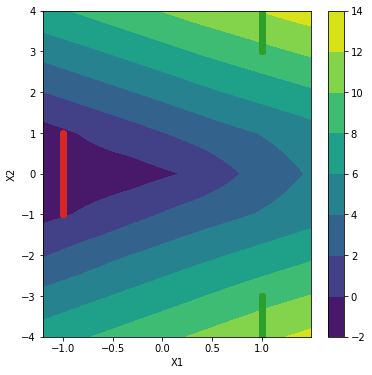

In [37]:
fig = plt.figure(figsize=(6,6))
cs = plt.contourf(X[:,0].reshape(xx.shape)[:,:,0],X[:,1].reshape(yy.shape)[:,:,0],Y.reshape(xx.shape)[:,:,0])
plt.xlabel("X1")
plt.ylabel("X2")
fig.colorbar(cs)
for i in range(4):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("focus_contour.png")#,bbox_inches='tight')


In [38]:
Y1 = Y1.detach().numpy()
Y1 = torch.softmax(torch.Tensor(Y1),dim=1)
_,Z4= torch.max(Y1,1)
Z1 = Y1[:,0]
Z2 = Y1[:,1]
Z3 = Y1[:,2]

In [39]:
Z4

tensor([0, 2, 0,  ..., 1, 0, 1])

In [40]:
#fig = plt.figure(figsize=(6,6))
# plt.scatter(X[:,0],X[:,1],c=Z1)
# plt.scatter(X[:,0],X[:,1],c=Z2)
# plt.scatter(X[:,0],X[:,1],c=Z3)
#cs = plt.contourf(X[:,0].reshape(xx.shape),X[:,1].reshape(yy.shape),Z1.reshape(xx.shape))
# #plt.colorbar(cs)
# cs = plt.contourf(X[:,0].reshape(xx.shape),X[:,1].reshape(yy.shape),Z2.reshape(xx.shape))
# #plt.colorbar(cs)
# cs = plt.contourf(X[:,0].reshape(xx.shape),X[:,1].reshape(yy.shape),Z3.reshape(xx.shape))
#plt.colorbar(cs)
# plt.xlabel("X1")
# plt.ylabel("X2")
#ax.view_init(60,100)
#plt.savefig("non_interpretable_class_2d.pdf",bbox_inches='tight')


In [41]:
avrg = []
with torch.no_grad():
  for i, data in  enumerate(train_loader):
          inputs , labels , fore_idx = data
          avg_inp,alphas = where(inputs)
          avrg.append(avg_inp)
avrg= np.concatenate(avrg,axis=0)

In [42]:
X[:,0],X[:,1]

(array([-1.20000005, -1.20000005, -1.19000006, ...,  1.48000002,
         1.49000001,  1.49000001]), array([-4., -4., -4., ...,  4.,  4.,  4.]))

In [43]:
# cs = plt.contourf(X[:,0].reshape(xx.shape)[:,:,0],X[:,1].reshape(yy.shape)[:,:,0],Z4.reshape(xx.shape)[:,:,1])
# for i in range(4):
#     plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.scatter(avrg[:,0],avrg[:,1])
# plt.savefig("decision_boundary.png",bbox_inches="tight")

In [44]:
true = []
pred = []
acc= 0
for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        avg_inp,alphas = where(inputs)
        outputs = what(avg_inp)
        _, predicted = torch.max(outputs.data, 1)
        true.append(labels)
        pred.append(predicted)
        acc+=sum(predicted == labels)

In [45]:
true = np.concatenate(true,axis=0)
pred = np.concatenate(pred,axis=0)

In [46]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true,pred)

array([[ 518,  394,   32],
       [ 375,  625,   13],
       [   0,    0, 1043]])